In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Correction device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc_mu = nn.Linear(512, 2)
        self.fc_logvar = nn.Linear(512, 2)
        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 28*28)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        h4 = torch.relu(self.fc4(h3))
        return torch.sigmoid(self.fc5(h4))

    def forward(self, x):
        x = self.flatten(x)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

model = VAE().to(device)
print(model)

Using cuda device
VAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
)


In [5]:

def vae_loss(recon_x, x, mu, logvar):
    x_flat = x.view(x.size(0), -1)
    BCE = nn.functional.binary_cross_entropy(recon_x, x_flat, reduction='mean')
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)) / x.size(0)
    return BCE + KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        recon_batch, mu, logvar = model(X)
        loss = vae_loss(recon_batch, X, mu, logvar)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            print(f"loss: {loss.item()/len(X):>7f}  [{(batch + 1) * len(X):>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            recon_batch, mu, logvar = model(X)
            test_loss += vae_loss(recon_batch, X, mu, logvar).item()
    test_loss /= size
    print(f"Test set: Avg loss: {test_loss:>8f}")

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 0.010875  [   64/60000]
loss: 0.006595  [ 6464/60000]
loss: 0.006493  [12864/60000]
loss: 0.006415  [19264/60000]
loss: 0.006221  [25664/60000]
loss: 0.006519  [32064/60000]
loss: 0.006179  [38464/60000]
loss: 0.006130  [44864/60000]
loss: 0.006336  [51264/60000]
loss: 0.006261  [57664/60000]
Test set: Avg loss: 0.006301
Epoch 2
-------------------------------
loss: 0.006153  [   64/60000]
loss: 0.006095  [ 6464/60000]
loss: 0.006180  [12864/60000]
loss: 0.006309  [19264/60000]
loss: 0.006132  [25664/60000]
loss: 0.006388  [32064/60000]
loss: 0.006048  [38464/60000]
loss: 0.006033  [44864/60000]
loss: 0.006253  [51264/60000]
loss: 0.006166  [57664/60000]
Test set: Avg loss: 0.006246
Epoch 3
-------------------------------
loss: 0.006156  [   64/60000]
loss: 0.005981  [ 6464/60000]
loss: 0.006206  [12864/60000]
loss: 0.006250  [19264/60000]
loss: 0.006087  [25664/60000]
loss: 0.006320  [32064/60000]
loss: 0.006062  [38464/60000]
loss: 0.0060

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = VAE().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

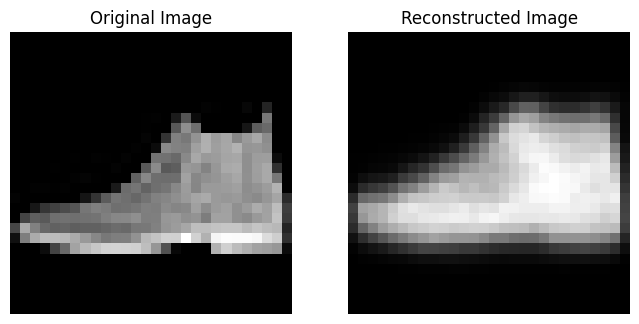

In [11]:
import matplotlib.pyplot as plt

model.eval()
x, y = test_data[0][0], test_data[0][1]  # x is the original image, y is the label (not used for display)
with torch.no_grad():
    x = x.to(device)
    # Add a batch dimension to the input
    x = x.unsqueeze(0)
    recon_x, _, _ = model(x)
    # Reshape the output prediction back to image shape
    reconstructed_image = recon_x.view(1, 1, 28, 28)

    # Display the original and reconstructed images
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Original Image
    axes[0].imshow(x.squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Reconstructed Image
    axes[1].imshow(reconstructed_image.squeeze().cpu().numpy(), cmap='gray')
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')
    plt.show()